# Data Bootcamp Project -- New York City's Income Distribution, 2016 
## Inès Ajimi

Income inequality has been on the rise since the 1970s and is considerably larger in the U.S. than in other OECD nations. In 2014, "Capital in the Twenty-First Century", a detailed study of inequality in income and wealth, posited that this increase may have been primarily due by increased compensation at the higher rungs of private firms. The 'working rich', as Piketty calls them to differentiate them from individuals whose wealth is primarily inherited, are then able to *further accrue wealth* through investments. The high rate of return of capital (e.g. investment portfolios) of the wealthiest households and the stagnant average wage growth have deepened those differences in income (Piketty & Saez [2003](https://eml.berkeley.edu/~saez/pikettyqje.pdf), [2014](http://piketty.pse.ens.fr/files/PikettySaez2014Science.pdf)).

Manhattan, as one of the biggest and the most unequal cities in the U.S., is therefore a particularly interesting area to study. This project thus focuses on the **geographic distribution of income inequality** in NYC, and more specifically Manhattan, at a census tract level. Using the 5 year *American Community Survey*, I look at factors usually thought to explain wage differentials such as education, sectors, industry, and other factors (primarily demographic) to try to shed light on some of these income distribution patterns. I conclude with a 'tale of two census tracts', which vividly illustrates the deep rifts present in the city.

--- 

## Set Up

### Downloading Packages

In [1]:
from IPython.display import display, Image 
import pandas as pd  
import matplotlib.pyplot as plt
import numpy as np 

from census import Census 
from us import states

import fiona 
import geopandas as gpd 
from shapely.geometry import Point, Polygon 

### Retrieving ACS data

I use the census API to retrieve information pertaining to every *census tract* in NYC (excluding Staten Island) in **2016**. Information on the variables used can be found [here](https://api.census.gov/data/2016/acs/acs5/groups.html).

(Note: this can be quite slow!)

In [2]:
my_api_key = '34e40301bda77077e24c859c6c6c0b721ad73fc7' 
c = Census(my_api_key)

In [3]:
code = ["NAME","B01001_001E", "B01001_026E", "B00002_001E", "B02001_002E", "B02001_003E", "B02001_005E", "B02001_008E",
        "B04004_001E",
       "B08303_001E", "B08302_001E", 
       "B15003_001E", "B15003_017E", "B15003_018E", "B15003_022E", "B15003_023E", "B15003_025E", 
        "B17001_001E",
        "B19013_001E",  
       "B19119_001E", "B19083_001E", "B19301_001E", "B19301A_001E", "B19301B_001E", "B19301D_001E",
       "B25031_001E", "B25111_009E", "B25111_010E", "B25111_011E", "B25104_001E", "B25071_001E"]


for i in range(2, 10): #retrieves all tranches of household income
    code.append("B19001_00" + str(i) + "E") #overall
    code.append("B19001A_00" + str(i) + "E") #white households
    code.append("B19001B_00" + str(i) + "E") #african american households
    
for i in range(10, 18): #retrieves all tranches of household income -- continued
    code.append("B19001_0" + str(i) + "E")
    code.append("B19001A_0" + str(i) + "E")
    code.append("B19001B_0" + str(i) + "E")
    
for i in range(1, 10): #retrieves all workers per industry
    code.append("C24070_00" + str(i) + "E")
    
for i in range(10, 14): #retrieves all workers per industry -- continue
    code.append("C24070_0" + str(i) + "E")

mnht = c.acs5.state_county_tract(code,  states.NY.fips, "061", Census.ALL)
mnht = pd.DataFrame(mnht)
blkn = c.acs5.state_county_tract(code,  states.NY.fips, "047", Census.ALL)
blkn = pd.DataFrame(blkn)
brx = c.acs5.state_county_tract(code,  states.NY.fips, "005", Census.ALL)
brx = pd.DataFrame(brx)
queens = c.acs5.state_county_tract(code,  states.NY.fips, "081", Census.ALL)
queens = pd.DataFrame(queens)

In [4]:
nyc = pd.concat([mnht, blkn, brx, queens])

In [5]:
nyc = nyc.rename(columns = {'B01001_001E': 'pop', 'B00002_001E': 'housing_units', "B01001_026E": "women", 
                            'B02001_002E': 'white', 'B02001_003E': 'af_am', 'B02001_005E': 'asian', 
                            "B15003_017E": "edu_hs", "B15003_018E": "edu_ged", "B15003_022E": "edu_ba",
                            "B15003_023E" : "edu_ma", "B15003_025E": "edu_phd",
                            "B19013_001E": "house_income", "B19301_001E" : "per_cap_income",  
                            "B19301A_001E" : "per_cap_income_white", "B19301B_001E" : "per_cap_income_af_am",
                            "B19119_001E" : "house_income_famsize",
                            "B19083_001E": "gini",
                            "C24070_001E": "work_total",
                            "C24070_002E": "work_agri", "C24070_003E": "work_construction", "C24070_004E" : "work_manufacturing", 
                            "C24070_005E": "work_wholesale", "C24070_006E": "work_retail", "C24070_007E": "work_transp",
                            "C24070_008E": "work_info", "C24070_009E": "work_finance",  "C24070_010E": "work_science", 
                            "C24070_011E": "work_education", "C24070_012E" : "work_arts", "C24070_013E": "work_other",
                            'NAME': 'name'    
})

There is **a lot** going on, but the variables will be brought in one at a time so it hopefully shouldn't be too hard to follow.

A word on some of the variables retrieved:
- `edu_` are the highest level of educational attainment (High School Diploma, Bachelor's, Master's, PhD)
- `house_income` is the **median** household income
- B19001_002E to B19001_017E are **tranches** of household income, from below 10,000 dollars a year to above 200,000
  - B19001A_00xE are white households only, B19001B_00xE African-American households
- B19119_001E is the **median** family income by family size
- C24070_00-E are the number of workers per industry
   - `work_agri` includes "Agriculture, forestry, fishing and hunting, and mining"
   - `work_transp` includes "Transportation and warehousing, and utilities"
   - `work_finance` includes "Finance and insurance, and real estate and rental and leasing"
   - `work_science` includes "Professional, scientific, and management, and administrative and waste management services"
   - `work_education` includes "Educational services, and health care and social assistance"
   - `work_arts` includes "Arts, entertainment, and recreation, and accommodation and food services"

### Cleaning/Formatting the DF

#### Removing NAs

Some census tracts are missing data (or aren't residental areas, e.g. Central Park) -- signalled by a 0 population count and/or a 0 housing unit count. I remove these observations.

In [6]:
nyc = nyc[(nyc["pop"] > 0) & (nyc["housing_units"] > 0)]

#### Creating new columns

First off, I group the number of people with a HS and GED diploma together (since those two are equivalent). I likely won't be using the GED data by itself afterwards. I also create a `edu_college` column in the `nyc` DF for to make the analysis easier.

In [7]:
nyc['edu_hs'] = nyc['edu_hs'] + nyc['edu_ged']

In [8]:
nyc['edu_college'] = nyc['edu_ba'] + nyc['edu_ma'] + nyc['edu_phd']

Then, I transform some of our variables into percentages to make them more easy to interpret:

In [9]:
for i in ["women", "white", "af_am", "asian", 'edu_hs', 'edu_college', 'edu_ba', 'edu_ma', 'edu_phd']: #creates percentage
    nyc[i] = nyc[i] / nyc["pop"]

To make my workers per industry data easier to work with, I group industries into rough sectors: the primary and secondary sector, which involves collecting or working on raw material, the tertiary sector, or service sector, with 'customer facing' jobs, and the 'quaternary' sector, where workers 'sell' knowledge/information. Construction workers would be included in the primary/secondary sector, retail workers into the tertiary sector, and bankers into the quaternary sector.

In [10]:
nyc["sec_a"] = nyc["work_agri"] + nyc["work_construction"] + nyc["work_manufacturing"] + nyc["work_transp"]
nyc["sec_b"] = nyc["work_wholesale"] + nyc["work_retail"]
nyc["sec_c"] = nyc["work_info" ]+ nyc["work_finance"]  + nyc["work_science"] + nyc["work_education"] + nyc["work_arts"] 

Then I create a percentage measure for all the above:

In [11]:
for i in ["work_agri", "work_construction", "work_manufacturing", "work_wholesale", "work_retail", "work_transp",
                            "work_info", "work_finance",  "work_science", "work_education", "work_arts", "work_other",
         "sec_a", "sec_b", "sec_c"]: 
    nyc[i] = nyc[i] / nyc["work_total"]

I also create a measure of population density, equal to the number of people per housing units:

In [12]:
nyc["density"] = nyc["pop"] / nyc["housing_units"]

Let's look at what we have for NYU's neighborhood:

In [13]:
nyc[(nyc["tract"] == "003400") & (nyc["county"] == "061")]

,housing_units,pop,women,white,af_am,asian,B02001_008E,B04004_001E,B08302_001E,B08303_001E,...,work_other,name,county,state,tract,edu_college,sec_a,sec_b,sec_c,density
34,157.0,6476.0,0.511581,0.788141,0.014824,0.14824,151.0,4177.0,4095.0,4095.0,...,0.03683,"Census Tract 34, New York County, New York",061,36,003400,0.524089,0.05067,0.068304,0.806696,41.248408


Everything looks good so far!

### Adding Shape Files for NYC Census Tracts

To graph my data, I need to merge our original dataset with census tract shapefiles (provided by [NYC Planning](https://www1.nyc.gov/site/planning/data-maps/open-data/districts-download-metadata.page)). This will add shapefiles for the census tracts, as well as neighborhood names.

In [14]:
nyc_map = gpd.read_file(r"nyct2010_18a\\nyct2010.shx")

In [15]:
nyc_map.head(3)

,CTLabel,BoroCode,BoroName,CT2010,BoroCT2010,CDEligibil,NTACode,NTAName,PUMA,Shape_Leng,Shape_Area,geometry
0,9,5,Staten Island,000900,5000900,I,SI22,West New Brighton-New Brighton-St. George,3903,7729.016794,2.497010e+06,"POLYGON ((962269.1260375977 173705.5001831055,..."
1,98,1,Manhattan,009800,1009800,I,MN19,Turtle Bay-East Midtown,3808,5534.199811,1.906016e+06,"POLYGON ((994133.507019043 214848.8975830078, ..."
2,100,1,Manhattan,010000,1010000,I,MN19,Turtle Bay-East Midtown,3808,5692.168737,1.860938e+06,"POLYGON ((993108.3057861328 216013.1307983398,..."


The Census Tract number, found under column CT2010 of this dataset, will be used as a merging key. Let's check that it is compatible with our Census data census tract.

In [16]:
nyc_map.dtypes

CTLabel        object
BoroCode       object
BoroName       object
CT2010         object
BoroCT2010     object
CDEligibil     object
NTACode        object
NTAName        object
PUMA           object
Shape_Leng    float64
Shape_Area    float64
geometry       object
dtype: object

In [17]:
nyc_map[nyc_map["CT2010"] == "003400"] #check using the East Village code

,CTLabel,BoroCode,BoroName,CT2010,BoroCT2010,CDEligibil,NTACode,NTAName,PUMA,Shape_Leng,Shape_Area,geometry
1494,34,4,Queens,003400,4003400,E,QN53,Woodhaven,4111,10367.893401,2.303270e+06,"POLYGON ((1025865.15838623 189386.0260009766, ..."
2062,34,3,Brooklyn,003400,3003400,I,BK31,Bay Ridge,4013,11210.699215,5.160782e+06,"POLYGON ((975184.8121948242 173802.7478027344,..."
2135,34,1,Manhattan,003400,1003400,I,MN22,East Village,3809,5503.314275,1.718525e+06,"POLYGON ((990340.0073852539 205029.4624023438,..."


Like in the ACS dataset, the column is in object form, and the census tract codes is formatted in the same way. However, census tract codes are reused across boroughs/counties. Therefore we'll need to merge on *both* tract numbers and borough names. 

The `nyc_map` DataFrame doesn't have a county column, so I need to find a way to merge it with the `nyc` DF county column. Since counties and boroughs are the same thing in NYC, I decided to switch the county codes in the `nyc` DF to Borough names. This makes the analysis easier (no need to look up the county codes every time to decifer my tables).

In [18]:
boro = {"081": "Queens", "005": "Bronx", "061": "Manhattan", "047" : "Brooklyn", "085": "Staten Island"} #county code dictionary
county = [] #empty county list

for i in nyc["county"]:
    county.append(boro[i]) #for every row in county, retrieves borough name associated w county code
        
nyc["county"] = county

I then rename the 'key' columns prior to the merge and narrow down the `nyc_map` DF to only the columns I need:

In [19]:
nyc_map = nyc_map.rename(columns = {'CT2010': 'tract', 'BoroName': 'county'})

In [20]:
nyc_map.columns

Index(['CTLabel', 'BoroCode', 'county', 'tract', 'BoroCT2010', 'CDEligibil',
       'NTACode', 'NTAName', 'PUMA', 'Shape_Leng', 'Shape_Area', 'geometry'],
      dtype='object')

In [21]:
nyc_map = nyc_map[['BoroCode', 'tract', 'NTAName', 'county', 'Shape_Leng', 'Shape_Area', 'geometry']]

The ShapeFile dataframe is ready for merging.

In [22]:
nyc = pd.merge(nyc, nyc_map, on  = ["county", "tract"], how = "left") 

In [23]:
nyc.head(3)

,housing_units,pop,women,white,af_am,asian,B02001_008E,B04004_001E,B08302_001E,B08303_001E,...,edu_college,sec_a,sec_b,sec_c,density,BoroCode,NTAName,Shape_Leng,Shape_Area,geometry
0,83.0,2791.0,0.533859,0.230383,0.064135,0.469366,20.0,2427.0,1056.0,1056.0,...,0.097098,0.097738,0.190950,0.580995,33.626506,1,Lower East Side,4748.325960,9.715994e+05,"POLYGON ((988548.2182006836 197770.3748168945,..."
1,160.0,7768.0,0.573378,0.367276,0.146885,0.281411,462.0,5699.0,2386.0,2386.0,...,0.220391,0.070491,0.117360,0.724409,48.550000,1,Lower East Side,8568.089235,3.315114e+06,(POLYGON ((989137.1102294922 196325.4387817383...
2,119.0,12554.0,0.524773,0.093516,0.120918,0.510435,95.0,10278.0,3852.0,3852.0,...,0.109368,0.164846,0.198113,0.495780,105.495798,1,Lower East Side,6970.634699,2.583418e+06,"POLYGON ((986961.1856079102 199553.6431884766,..."


For the GeoPandas mapping function to work, I need to make sure our merged DataFrame is of a GeoDF, not a regular DF.

In [24]:
type(nyc)

pandas.core.frame.DataFrame

In [25]:
nyc = gpd.GeoDataFrame(nyc) #changes type of DF

In [26]:
type(nyc)

geopandas.geodataframe.GeoDataFrame

--- 

## Socio-Economic Characteristics of NYC: 2016

### Income

I start off by looking at the distribution of **income** across the city in **2016**. 

Since the dataset is pretty big (with over 2000 rows), I start my analysis by looking at county/borough-level information. I group all the data by borough and calculate the *mean* per capita income and the *mean* median household income for each of them. The results are displayed in the graphs below:

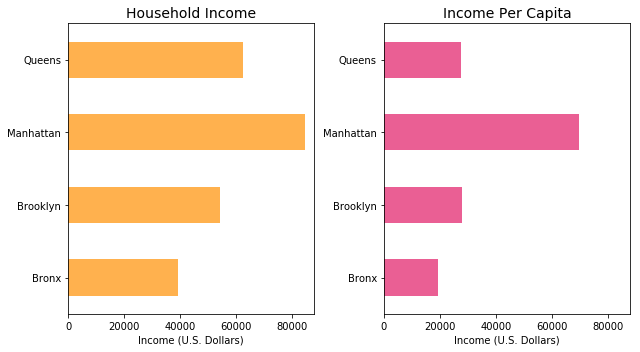

In [27]:
fig, ax = plt.subplots(1, 2, figsize = (9, 5))
nyc.groupby("county")["house_income"].mean().plot.barh(ax = ax[0], color = "#ffb14e") #plot average median househould income
nyc.groupby("county")["per_cap_income"].mean().plot.barh(ax = ax[1], color = "#ea5f94") #plot average income per capita

ax[0].set_title("Household Income", size  = 14)
ax[1].set_title("Income Per Capita", size  = 14)

for i in range(0, 2):
    ax[i].set_xlabel("Income (U.S. Dollars)")
    ax[i].set_ylabel("")
    ax[i].set_xlim(0, 88000)

fig.tight_layout(w_pad=0.5)
plt.show() 

The first salient fact is Manhattan has the highest income per capita and median household income by far, and the Bronx the lowest. The second is that those differences are less acute for *household* income than for *per capita* income: Manhattan's per capita income is 2.5 that of Brooklyn, but its average household income is "only" 1.55 that.

(Note: the differences may be smaller when it comes to *household* income because this measure is based on the *median*. It is therefore much less likely to be skewed by a few outliers than average per capita income. It also does not control for household size: it could be that households work/pool their resources to make sure the overall household income is sufficient. Conversely, individuals with high income per capita may be more likely to live by themselves, because (for example) they are willing to pay a premium for some solo space. To control for this, I add a measure of household income per household size later on).

So income is unevenly distributed *across* boroughs -- but what about *within* boroughs?

In [28]:
nyc.groupby("county")[['house_income',  "per_cap_income"]].aggregate(["mean", "median"])

house_income          per_cap_income         
                   mean   median           mean   median
county                                                  
Bronx      39311.203647  33365.0   19482.747748  16132.0
Brooklyn   54264.913102  48398.5   27863.969251  24038.5
Manhattan  84555.191336  81867.0   69823.580645  64135.0
Queens     62336.878505  60629.0   27574.839813  25760.0

The table above shows the mean and median of household and per capita income. If the mean is significantly higher than the median (as is the case for per capita income in Manhattan, for example), this suggests **a few** *neighborhoods with high incomes are* **skewing** *the distribution*.

Let's look at the same data at the Neigbhorhood Tract (NTA) level. This will allow me to look at how neighborhoods with the *highest* and *lowest* per capita income compare. 

In [29]:
nyc.groupby("NTAName")[['house_income', 'per_cap_income']].aggregate("mean").sort_values("per_cap_income", ascending = False).head(4)

,house_income,per_cap_income
NTAName,,
Upper East Side-Carnegie Hill,170766.285714,157662.785714
Turtle Bay-East Midtown,124146.600000,122504.300000
SoHo-TriBeCa-Civic Center-Little Italy,141865.500000,118857.800000
Lincoln Square,125998.000000,108625.250000


In [30]:
nyc.groupby("NTAName")[['house_income',  'per_cap_income']].aggregate("mean").sort_values("per_cap_income").head(4)

,house_income,per_cap_income
NTAName,,
Williamsburg,24040.714286,10518.285714
Claremont-Bathgate,22790.250000,11216.750000
Belmont,24076.400000,11395.000000
East Tremont,20937.583333,11679.000000


There is, indeed, *considerable* variation in incomes across neighborhoods. Williamsburg, for instance, has an annual per capita income of 10,518 dollars, while Lincoln Square has a per capita income of 108,625 dollars -- approx. **ten times** more. As one might expect given the bar charts previously shown, the NTAs with the highest incomes are all in Manhattan and three out of the four with the lowest incomes are in the Bronx.

This doesn't tell me the range in Manhattan however (since the none of the neighborhoods with the lowest incomes are in that borough), so I find them below:

In [31]:
nyc[nyc["county"] == "Manhattan"].groupby("NTAName")[['house_income',  'per_cap_income']].aggregate("mean").sort_values("per_cap_income").head(4)

,house_income,per_cap_income
NTAName,,
Manhattanville,29598.500000,16951.750000
East Harlem North,29455.181818,20133.909091
Washington Heights South,39757.750000,20817.916667
Marble Hill-Inwood,43364.857143,24368.857143


While the richest neighborhoods were relatively spread-out (the Upper East Side is, obviously, in the Upper East Side, East Midtown in East Midtown, Soho-Tribeca is Downtown and Lincoln Square is in the lower rungs of the Upper West Side), these neighborhoods are all roughly located in Uptown Manhattan (above 125th st).

To have a better idea of how income is distributed across Manhattan, I map household income, per capita income, and household income per household size below.

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


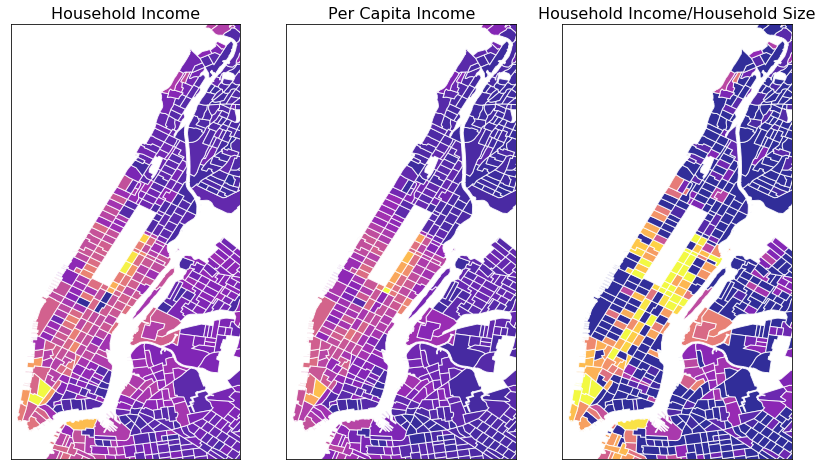

In [32]:
fig, ax = plt.subplots(1,3, figsize = (14,8))
nyc.plot(ax = ax[0], edgecolor='white', column = "house_income", cmap = "plasma", alpha = 0.85) 
nyc.plot(ax = ax[1], edgecolor='white', column = "per_cap_income", cmap = "plasma", alpha = 0.85) 
nyc.plot(ax = ax[2], edgecolor='white', column = "house_income_famsize", cmap = "plasma", alpha = 0.85) 

x1, x2, y1, y2 = 978000, 1010000, 189800, 260100 #ax limits

for i in range(0, 3):
    ax[i].get_xaxis().set_visible(False) 
    ax[i].get_yaxis().set_visible(False)
    ax[i].set_xlim(x1, x2)
    ax[i].set_ylim(y1, y2)

ax[0].set_title("Household Income", size  = 16)
ax[1].set_title("Per Capita Income", size  = 16)
ax[2].set_title("Household Income/Household Size", size  = 16)
plt.show()

First, it appears that household income per household size is **much more** unevenly distributed than household income and per capita income. Per capita income and household income also seem to have geographic overlap. Secondly, while the neighborhoods which with the highest per capita incomes were relatively dispersed, the *tracts* with the highest incomes (for all three metrics) are primarily clustered in the Upper East Side. Thirdly, these tracts (in the UES and in Soho) co-exist right alongside low income tracts.

The extremely unequal distribution of household income per household size lend support to the argument that the way household grouping occurs reinforces social inequities. It therefore seems that taking household income per household size is a much more informative measure of income inequality than household income. 

(Note: it may be exacerbated by the trend of high earners to pair up with other high earners).

Before zooming in, it would be nice to have a more formal way to confirm that those are areas of high income inequality. Luckily, the ACS computes Census Tract-level **Gini coefficients**. Roughly speaking, the Gini coefficient is the *deviation* of  the cumulative share of the population holding a certain level of income from the expected share if the income were perfectly evenly distributed. The coefficient ranges from 0 to 1, with 0 representing a perfectly even distribution and 1 a highly uneven distribution where one individual holds all of the wealth.

Let's go back and find the neighborhoods with the highest Gini Coefficients.

In [33]:
nyc.groupby("NTAName")[["gini"]].aggregate("mean").sort_values("gini", ascending = False).head(4)

,gini
NTAName,
Upper East Side-Carnegie Hill,0.569864
East Harlem South,0.567382
Upper West Side,0.565144
SoHo-TriBeCa-Civic Center-Little Italy,0.562940


This confirms the areas I spotted earlier (the UES, Soho) have a particularly unequal income distribution -- some of the highest in *in all of NYC*, with a Gini Coefficient of approx. 0.56 for both. There are also two new NTAs in this group: the Upper West Side and East Harlem South.

I'll go back to the the Upper East Side/South Harlem once I have more information on NYC in general. But first, let's look at some factors that explain this income distribution -- i.e. how did the high earners get there?

Before doing so, I want to address a caveat of this project. 

Given the nature of the data, I can only look at a snapchot of the city *at a specific point in time*. This is a problem when trying to explain income distribution because individuals' incomes today are quite likely to be determined by their family background: people born into wealthy families are likely to be wealthy themselves; conversely, people coming from less wealthy backgrounds are more likely to remain less wealthy [(Chetty, Hendren, Kline & Saez 2014)](http://www.nber.org/papers/w19843.pdf). In other words, income inequality is **partly self-perpetuating**, because of *low intergenerational socio-economic mobility*. 

One reason for this is that less wealthy families are more vulnerable to economic shocks [(IMF 2002)](https://www.imf.org/en/Publications/WP/Issues/2016/12/30/Financial-Crises-Poverty-and-Income-Distribution-15562). Another is that wealthy families are able to make greater investments in their children's future, by hiring tutors or paying for college for example. College is especially important because (1) it has a high 'return-on-investment' (i.e. it leads to significantly better paid positions) [(Brookings 2013)](https://www.brookings.edu/wp-content/uploads/2016/06/THP_13EconFacts_FINAL.pdf) and (2) it is extremely costly, due to both its explicit (i.e. tuition) and opportunity cost (i.e. forgone income). Therefore children from a higher income household are more likely to go to college than from lower income households [(Pew Research 2014)](http://www.pewresearch.org/fact-tank/2014/01/15/college-enrollment-among-low-income-students-still-trails-richer-groups/) and more selective colleges as well (Brookings); they are then likely to have a higher paying job; they may, in turn, have children who will benefit from the accrued wealth of their parents.

The 'stickiness' of income inequality is also likely to be reflected in the geographic distribution of income. Obviously, neighborhoods populated by citizens with higher income will having higher rent/housing prices. Richer individuals may also be more likely to own their housing, rather then rent, limiting their ability to move. They might also be more likely to invest in their neighborhood (e.g. local schools), which will make the location more attractive and expensive, further restricting it to lower income households. One example of a 'historically rich' neigbhorhood is the Upper East Side: it has been the bastion of the wealthy since *at least* the 1900s.

Showing factors such as those shaped NYC today would require data going back *much further* in time or the use of supplementary historical sources. Unfortunately, this project only captures the years around 2016. It is therefore hard for me to establish causation between income per capita and the factors I examine, absent the use of regression analysis. 

What I try to do instead is look at the distribution of my variables, check whether it conforms to economic theory, and try to approximately measure its 'fit' with the income distribution.

### Education

I mentionned earlier that education was likely to a factor in income inequality. Indeed, college commands a significant **wage premium**. 

Economists typically explain this wage premium by looking at the interaction between supply and demand of 'skilled' versus 'unskilled' workers (a somewhat vague definition, subject to change over time). The increase in the college wage-premium since the 1980s is then explained, on the one hand, by an increased demand for skilled workers, due to technological change (i.e. computerization), and a (comparatively) slower increase insupply, due to high tuition costs.

The high-school wage premium has, by contrast, increased at a much slower pace, as the supply of high-school graduates has increased much faster than its demand. Moreover, high-school graduates have gone from being considered 'skilled' to 'unskilled' workers during the 21st Century, restricting their ability to work higher paid, 'skilled' jobs [(Goldin & Katz 2009)](http://piketty.pse.ens.fr/files/GoldinKatz2009.pdf). 

I therefore expect the average income per capita per area to be highly sensitive to the percentage of college graduates and much less sensitive to the percentage of high-school graduates.

I start by looking at the education levels across the four boroughs.

In [34]:
nyc.groupby("county")[["edu_hs","edu_college"]].mean()

,edu_hs,edu_college
county,,
Bronx,0.173551,0.119012
Brooklyn,0.176985,0.212574
Manhattan,0.095769,0.411362
Queens,0.194353,0.202676


Clearly, Manhattan is the borough with the 'best educated' population by these measures (the percentages don't sum up to one because I did not include a measure of citizens not having graduate high-school or other, specific degrees which are computed separately by the ACS(e.g. nursing).

I then break it down by degree:

In [35]:
nyc.groupby("county")[["edu_hs", "edu_ba", "edu_ma", "edu_phd"]].mean()

,edu_hs,edu_ba,edu_ma,edu_phd
county,,,,
Bronx,0.173551,0.081704,0.032052,0.005256
Brooklyn,0.176985,0.139018,0.066710,0.006846
Manhattan,0.095769,0.246691,0.137170,0.027501
Queens,0.194353,0.136615,0.059674,0.006388


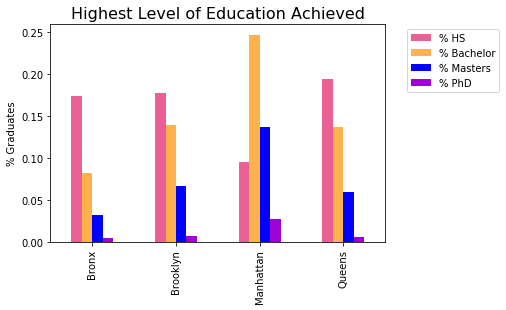

In [36]:
fig, ax = plt.subplots()
boro_edu = nyc.groupby("county")[["edu_hs", "edu_ba", "edu_ma", "edu_phd"]].mean()
boro_edu.plot.bar(ax = ax, color = ["#ea5f94", "#ffb14e", "#0000ff", "#9d02d7"])
ax.set_title("Highest Level of Education Achieved", size  = 16)
ax.set_xlabel("")
ax.set_ylabel("% Graduates")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, labels = ['% HS', '% Bachelor', '% Masters', '% PhD'])
plt.show() 

Manhattan is still the most educated borough across all measures: it has more Bachelors' holders than other boroughs have High School graduates! This is consistent with my previous finding that Manhattan had the highest average per capita income.

I quickly check whether education is correlated with income below:

In [37]:
nyc[["edu_hs", "edu_college", "per_cap_income"]].corr()["per_cap_income"]

edu_hs           -0.588415
edu_college       0.831565
per_cap_income    1.000000
Name: per_cap_income, dtype: float64

College-level education is, indeed, correlated with a higher per capita income.

I go one step further and look at the correlation between per capita income and different college degrees:

In [38]:
nyc[["edu_ba", "edu_ma", "edu_phd", "per_cap_income"]].corr()["per_cap_income"]

edu_ba            0.764181
edu_ma            0.806345
edu_phd           0.637176
per_cap_income    1.000000
Name: per_cap_income, dtype: float64

It looks like the strongest correlation is for Masters' holders, followed by Bachelors' holders. The weaker correlation for PhD holders is likely due to the nice specialization of PhDs, which tends to lead to careers in academia, a field less lucrative than the private sector.

How is 'education' distributed across Manhattan?

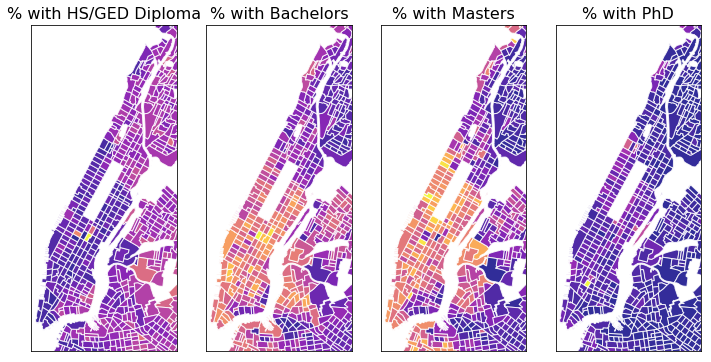

In [39]:
fig, ax = plt.subplots(1, 4, figsize = (12, 6)) 
nyc.plot(ax = ax[0], edgecolor='white', column = "edu_hs", cmap = "plasma", alpha = 0.85) 
nyc.plot(ax = ax[1], edgecolor='white', column = "edu_ba", cmap = "plasma", alpha = 0.85) 
nyc.plot(ax = ax[2], edgecolor='white', column = "edu_ma", cmap = "plasma", alpha = 0.85) 
nyc.plot(ax = ax[3], edgecolor='white', column = "edu_phd", cmap = "plasma", alpha = 0.85) 

x1, x2, y1, y2 = 978000, 1010000, 189800, 260100

for i in range(0, 4):
    ax[i].get_xaxis().set_visible(False) 
    ax[i].get_yaxis().set_visible(False)
    ax[i].set_xlim(x1, x2)
    ax[i].set_ylim(y1, y2)

ax[0].set_title("% with HS/GED Diploma", size  = 16)
ax[1].set_title("% with Bachelors", size  = 16)
ax[2].set_title("% with Masters", size  = 16)
ax[3].set_title("% with PhD", size  = 16)

plt.show()

It looks like Bachelors' and Masters' holders are fairly well distributed within Manhattan (a bit less so towards the north). NYU has the highest concentration of PhD holders in the city (higher than Morningside Heights (near Columbia University)) (this might be because NYU professors have housing close to campus, while Columbia professors are more likely to commute).

Now to my main (sub-)question: *is the geographic distribution of education in Manhattan consistent with the distribution of per capita income?*

(I showed previously that, in general, education was correlated with income, but this could result simply from neigbhorhoods with above-average per capita income having an above-average education-level -- i.e. a general correlation between income and education. What I want to determine here is whether education can explain the presence of tracts with extremely high per capita income.)

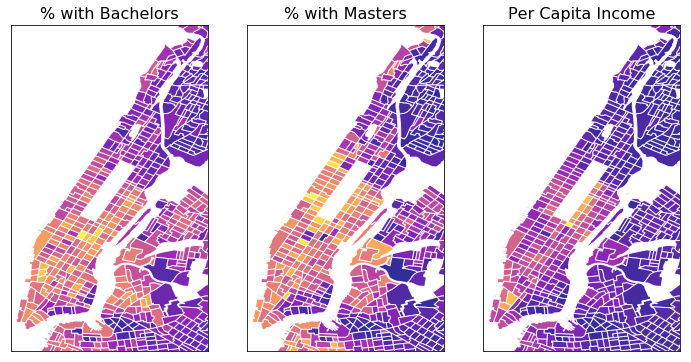

In [40]:
fig, ax = plt.subplots(1, 3, figsize = (12, 6)) 
nyc.plot(ax = ax[0], edgecolor='white', column = "edu_ba", cmap = "plasma", alpha = 0.85) 
nyc.plot(ax = ax[1], edgecolor='white', column = "edu_ma", cmap = "plasma", alpha = 0.85) 
nyc.plot(ax = ax[2], edgecolor='white', column = "per_cap_income", cmap = "plasma", alpha = 0.85) 

x1, x2, y1, y2 = 978000, 1010000, 189800, 260100

for i in range(0, 3):
    ax[i].get_xaxis().set_visible(False) 
    ax[i].get_yaxis().set_visible(False)
    ax[i].set_xlim(x1, x2)
    ax[i].set_ylim(y1, y2)

ax[0].set_title("% with Bachelors", size  = 16)
ax[1].set_title("% with Masters", size  = 16)
ax[2].set_title("Per Capita Income", size  = 16)

plt.show()

Though higher-level education is correlated with higher per capita income, it does **not** entirely explain the distribution of the latter. Some tracts, particularly in Brooklyn, have a high concentration of Bachelors/Masters' holders, but an average per capita income. Other tracts (Soho/Tribeca) have a lower level of education but a higher per capita income.

The graph below illustrates this quite well:

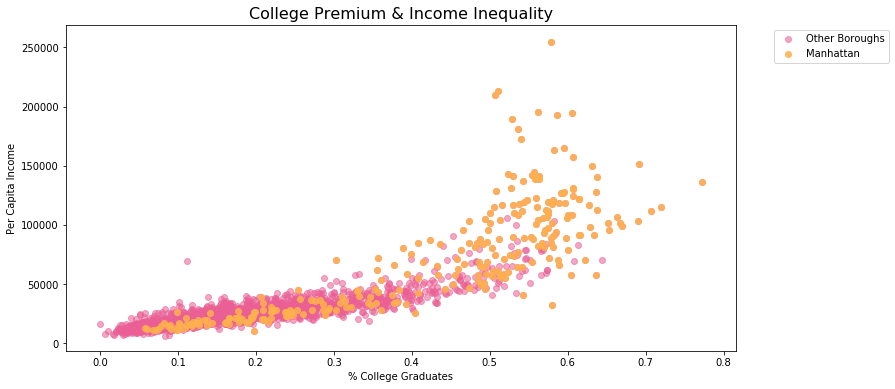

In [41]:
fig, ax = plt.subplots(figsize = (12, 6)) 
ax.scatter(nyc["edu_college"], nyc["per_cap_income"], color = "#ea5f94", alpha = 0.55) #all points
ax.scatter(nyc[nyc["county"] == 'Manhattan']["edu_college"], nyc[nyc["county"] == 'Manhattan']["per_cap_income"], 
           color = "#ffb14e", alpha = 0.85) #manhattan only
ax.set_title("College Premium & Income Inequality", size  = 16)
ax.set_xlabel("% College Graduates")
ax.set_ylabel("Per Capita Income")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, labels = ['Other Boroughs', 'Manhattan'])
plt.show()

There is a clear linear relationship between the average per capita income of a census tract and its proportion of college graduates -- *up to a point*. After 50 percent of college graduates, the variation in per capita income increases dramatically: a neighborhood with, say, 0.54 percent of college graduates could have an average per capita income of 100,000 dollars or twice that. 

It could be that what matters isn't only *having* a college degree but the *field* of the degree as well. Some degrees lead to more lucrative professions than others; others have a low educational-requirement for entry, yet can still be very lucrative (e.g. fashion). I now turn to the distribution of workers per industry.

### Industry

I will attempt to extent my brief overview of the demand-supply framework of educational 'wage-premiums' to wage-differential across economic 'sectors'. 

There obviously is considerable overlap between the two. The 'primary' and 'secondary' sectors rely on 'unskilled' workers, so jobs in that sector will on average be lower paid than the 'skilled' positions in the 'quatnerary' sectors. However, there is likely wage variation at an *industry-level*. 

Two factors have been put forward by economists to explain recent changes in wages across sectors: the first are technological changes and the second are globalization-induced competitive pressures. Technological changes could theoreticaly either decrease or increase the demand for workers, depending on whether labor and capital are *substitutes* or *complements*. Katz and Autor [(1999)](https://economics.mit.edu/files/11676) find that, in skill-intensive industries (e.g. finance), they tend to be complements: as a result, the increased use of technology (e.g. complicated quantitative pricing models, high-frequency trading) has led to an increased demand for skilled workers. In addition, increased labor productivity may lead to increased wages.

The manufacturing sector, on the other hand, has faced increased competition from overseas, which is thought to have created downward pressures on their wages.

I'll start by looking at the correlation of workers in each sectors with the per capita income. This will allow me to find which sectors are best paid.

A quick reminder: 
- `sec_a` is the primary and secondary sector, e.g. construction workers
- `sec_b` is the tertiary sector, e.g. trade
- `sec_c` is the 'quaternary' sector, e.g. artists, bankers

As before, I look at how this data is distributed across boroughs:

In [42]:
nyc.groupby("county")[["sec_a", "sec_b", "sec_c"]].mean()

,sec_a,sec_b,sec_c
county,,,
Bronx,0.157335,0.140553,0.605991
Brooklyn,0.157180,0.124597,0.624661
Manhattan,0.074192,0.102762,0.753090
Queens,0.191304,0.130163,0.571555


The majority of jobs in NYC are in the quaternary sector. The primary + secondary and tertiary sector are roughly the same size (16.66 and 12.60 percent respectively, for the city-wide average). Once again, Manhattan distinguishes itself from the other NYC boroughs: almost three-quarters of its population works in the 'quaternary' sector, much more than the city average of 62.23 percent. This is consistent with the fact that Manhattan has the highest income per capita in NYC.

To illustrate this point, I show Manhattan's 'sector' pie-chart below:

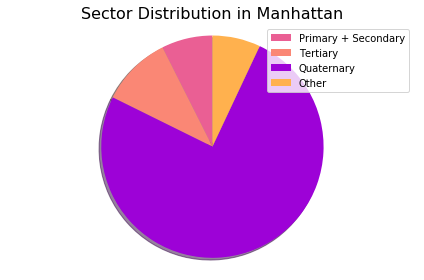

In [43]:
sizes = list(nyc[nyc["county"] == "Manhattan"][["sec_a", "sec_b", "sec_c"]].mean()) #takes the average proportion of workers per sector, puts it in a list
sizes.append(1 - sum(sizes)) # this appends a residual 'other' category to the list (sum of percentages shld add to 1)
colors = ["#ea5f94", "#fa8775", "#9d02d7", "#ffb14e"] #colors for the pie
patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90) #creates pie
plt.legend(patches, ["Primary + Secondary", "Tertiary", "Quaternary", "Other"], loc="best")
plt.axis('equal')
plt.title("Sector Distribution in Manhattan", size = 16)
plt.tight_layout()
plt.show() #code adapted from #https://pythonspot.com/matplotlib-pie-chart/

Given the theory outlined above and my finding that Manhattan has the most workers in the 'quaternary' sector, I want to verify that the 'quaternary' sector is associated to higher income per capita (as it would if workers in the sector had wages higher than average). To do so, I look at the correlation between income per capita and the percentage of workers working in a given sector:

In [44]:
nyc[["sec_a", "sec_b", "sec_c", "per_cap_income"]].corr()["per_cap_income"]

sec_a            -0.497709
sec_b            -0.292330
sec_c             0.608560
per_cap_income    1.000000
Name: per_cap_income, dtype: float64

The "quartnerary" sector jobs are, indeed, strongly (and positively) correlated to income per capita.

These sectors contain pretty disparate industries (especially in the case of the quarternary sector, which includes artists and realtors), so let's break it down one sector at a time.

In [45]:
nyc[["sec_a", "work_agri", "work_construction", "work_manufacturing", "work_transp", "per_cap_income"]].corr()["per_cap_income"].iloc[:-1]
#iloc[:-1] excludes the per_cap_income row 

sec_a                -0.497709
work_agri            -0.052422
work_construction    -0.322115
work_manufacturing   -0.146102
work_transp          -0.435331
Name: per_cap_income, dtype: float64

From these industries, the agricultural sector is the one with the least negative correlation to income (in that there is almost no correlation between per capita income and the percentage of workers in the agricultural sector, likely because there are so few agricultural workers in New York City), followed by manufacturing, construction, and transportation.

In [46]:
nyc[["sec_b", "work_wholesale", "work_retail", "per_cap_income"]].corr()["per_cap_income"]

sec_b            -0.292330
work_wholesale    0.024272
work_retail      -0.339435
per_cap_income    1.000000
Name: per_cap_income, dtype: float64

This tertiary sector only has two industries: the first, wholesale retail, is uncorrelated to per capita income, and the second, retail sales, is negatively related to income. The level of this correlation is comparable to that the construction sector.

In [47]:
nyc[["sec_c", "work_info", "work_finance",  "work_science", "work_education", "work_arts", "per_cap_income"]].corr()["per_cap_income"]

sec_c             0.608560
work_info         0.527923
work_finance      0.773834
work_science      0.662013
work_education   -0.299838
work_arts        -0.209982
per_cap_income    1.000000
Name: per_cap_income, dtype: float64

There is more variation in the quaternary sector. Clearly, workers in some industries (information, finance, science) tend to live in neighborhoods with higher per capita income than others (education, arts). This wage differential could either be due a difference in industry-specific skill supply/demand or in the marginal productivity (measured by profit) of workers.

(Arguably, `work_education` (which encompasses "educational services, ...health care and social assistance") and `work_arts` (which includes the "arts, entertainment, and recreation, and accommodation and food services") could've been classified as tertiary sector jobs. Appropriately segmenting these categories is tricky and somewhat arbitrary because of how broad they are.)

Let's now try to see if the industries with the strongest positive correlation to income correspond *geographically* with Manhattan's per capita income distribution:

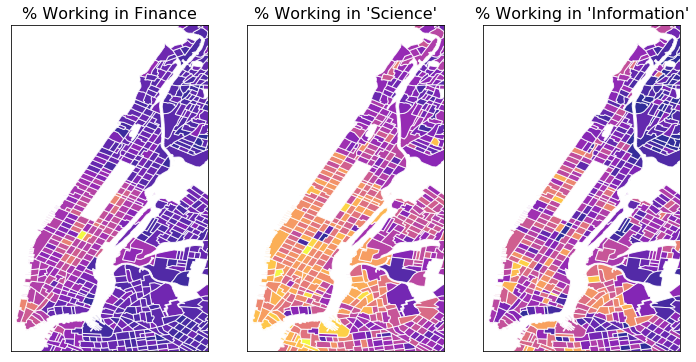

In [48]:
fig, ax = plt.subplots(1, 3, figsize = (12, 6)) 
nyc.plot(ax = ax[0], edgecolor='white', column = "work_finance", cmap = "plasma", alpha = 0.85) 
nyc.plot(ax = ax[1], edgecolor='white', column = "work_science", cmap = "plasma", alpha = 0.85) 
nyc.plot(ax = ax[2], edgecolor='white', column = "work_info", cmap = "plasma", alpha = 0.85) 

x1, x2, y1, y2 = 978000, 1010000, 189800, 260100

for i in range(0, 3):
    ax[i].get_xaxis().set_visible(False) 
    ax[i].get_yaxis().set_visible(False)
    ax[i].set_xlim(x1, x2)
    ax[i].set_ylim(y1, y2)

ax[0].set_title("% Working in Finance", size  = 16)
ax[1].set_title("% Working in 'Science'", size  = 16)
ax[2].set_title("% Working in 'Information'", size  = 16)

plt.show()

Finance looks like it maps out the best. Scientific/management/etc jobs also map out well but, because the category is so broad, they are more spread out in the city, making it harder to pinpoint which job characteristics could be correlated to higher income. Finally, 'information' jobs don't map out as well -- there is a high concentration of workers in Brooklyn, in an area with relatively low per capita income.

However, the high concentration of high income per capita individuals in the UES along 5th Avenue and in Soho-Tribeca remains unexplained. 

In [49]:
nyc["high_paid"] = nyc["work_info"] + nyc["work_finance"] + nyc["work_science"]

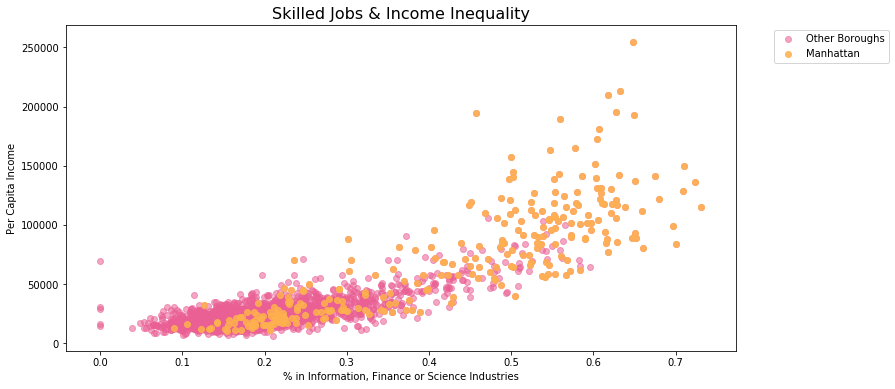

In [50]:
fig, ax = plt.subplots(figsize = (12, 6)) 
ax.scatter(nyc["high_paid"], nyc["per_cap_income"], color = "#ea5f94", alpha = 0.55) #all points
ax.scatter(nyc[nyc["county"] == 'Manhattan']["high_paid"], nyc[nyc["county"] == 'Manhattan']["per_cap_income"], 
           color = "#ffb14e", alpha = 0.85) #manhattan only
ax.set_title("Skilled Jobs & Income Inequality", size  = 16)
ax.set_xlabel("% in Information, Finance or Science Industries")
ax.set_ylabel("Per Capita Income")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, labels = ['Other Boroughs', 'Manhattan'])
plt.show()

As the graph above shows, there again is a significant increase in variation in per capita income for a given percentage of workers per industry past the 0.5 point. 

There is an obvious problem here in that there are **unobserved** differences in worker characteristics (an omitted variable issue). For instance, *experience/seniority* could explain within-industry wage industry. A good proxy for this would've been age by industry, but the ACS does not provide this information. 

Another 'omitted variable' explaining the distribution of individuals per neighborhood could be *wealth*. Wealth, rather than income, may explain location decision, especially in the case of home owners (buying a house or getting a mortgage is a big investment, which is easier to do when buttressed by pre-existing equity rather than 'flowing' income). It is therefore likely for neighborhood such as UES, which has been a harbour for the New York 'elite' for centuries, that the people who live there were able to do so because they came from wealthy families.

### Demographics

Demographics are another factor to consider when trying to understand the geographic distribution of income in NYC today. Put bluntly, the United States is not a race-blind society. Countless studies have shown both the continued effects of the U.S. current and past discrimination and bias continue to affect both the earning potential of individuals according to race, gender, sexual orientation, etc.

Race is particularly important to consider when looking at housing patterns because of the existence of **racial segregation**. Indeed, despite being renowned for its diversity, NYC is one of the most segregated cities in America.

Racial segregation has its roots in both individuals' choices (e.g. 'white flight') and public policy. In *The Color of Law*, Historian Richard Rothstein outlines how the federal and local government's policies supported and even contributed to segregation in the 20th Century. Following the Great Depression, the Federal Government initiated a program encouraging home ownership, the Home Owners' Loan Corporation (HOLC), which repurchased existing mortgages from households at risk of defaulting and restructured them into low-interest, amortized mortgages. In order to do so, the HOLC rated neighborhoods based on their riskiness of default. Neighborhoods with more than 5 percent of African-American households automatically received the worst rating ("Hazardous"). As a result, African-Americans were excluded from the commercial loan market and were exposed to predatory loans. African-Americans were also left out of many other federal programs (the Federal Housing Administration insured bank mortages conditional on the buildings being 'white-only', African-Americans were prohibited from holding most positions in public government). African-Americans were therefore prevented from building equity in the form of real estate. These policies have also been found to have had lasting effects on home ownership rates and credit ratings ([Aaronson, Hartley, & Mazumder 2017](https://www.chicagofed.org/publications/working-papers/2017/wp2017-12)).

(Note: the ["Mapping America"](https://dsl.richmond.edu/panorama/redlining/#loc=11/40.7940/-73.9570&opacity=0.8&city=manhattan-ny) project gives access to interactive versions of the HOLC maps. These maps, dating back to the 1940s, show that a large proportion of Manhattan (54 percent, to be exact) received the worst rating ("Hazardous"), for reasons often explicitly based on race). 

I start off by looking at the differences in demographics between boroughs:

In [51]:
nyc.groupby("county")[['white',  'af_am', 'asian']].aggregate(["mean", "median"])

white               af_am               asian          
               mean    median      mean    median      mean    median
county                                                               
Bronx      0.232229  0.145395  0.323510  0.281671  0.038736  0.020084
Brooklyn   0.444850  0.443702  0.334503  0.118678  0.111532  0.052519
Manhattan  0.570242  0.650569  0.155302  0.058905  0.124688  0.088147
Queens     0.407136  0.399589  0.205653  0.044870  0.230825  0.189022

Residential segregation is already visible from the borough-level aggregates: one-third of Brooklyn's population is African-American, but the median percentage of African-Americans per census track is of 11% only.

This is even clearer graphically:

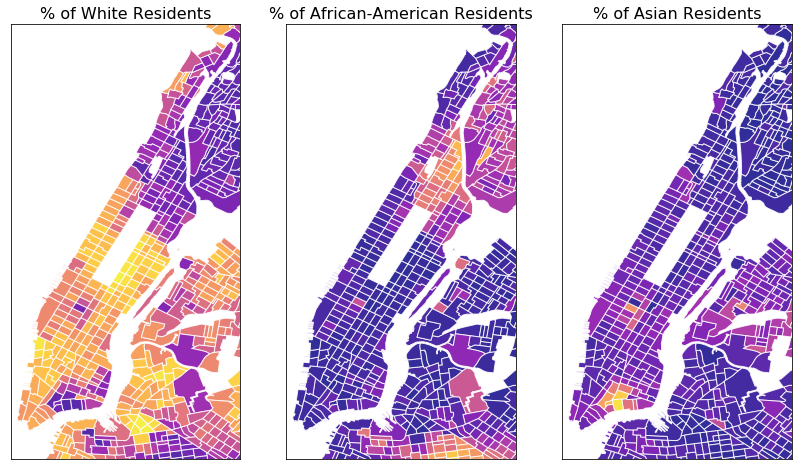

In [52]:
fig, ax = plt.subplots(1, 3, figsize = (14, 8)) 
nyc.plot(ax = ax[0], edgecolor='white', column = "white", cmap = "plasma", alpha = 0.85) 
nyc.plot(ax = ax[1], edgecolor='white', column = "af_am", cmap = "plasma", alpha = 0.85) 
nyc.plot(ax = ax[2], edgecolor='white', column = "asian", cmap = "plasma", alpha = 0.85) 

x1, x2, y1, y2 = 978000, 1010000, 189800, 260100

for i in [0, 1, 2]:
    ax[i].get_xaxis().set_visible(False) 
    ax[i].get_yaxis().set_visible(False)
    ax[i].set_xlim(x1, x2)
    ax[i].set_ylim(y1, y2)

ax[0].set_title("% of White Residents", size  = 16)
ax[1].set_title("% of African-American Residents", size  = 16)
ax[2].set_title("% of Asian Residents", size  = 16)
plt.show()

White residents are spread out across Manhattan; African-American and Asian residents, however, are mainly located in smaller geographic 'pockets', Harlem and Chinatown respectively.

Consider this contrasting example. Though gender impacts earnings, there is no recent history of gender-based segregation in the city. The map below should therefore show the contrast between a "neutral" distribution and a skewed distribution of a population across a geographic space.

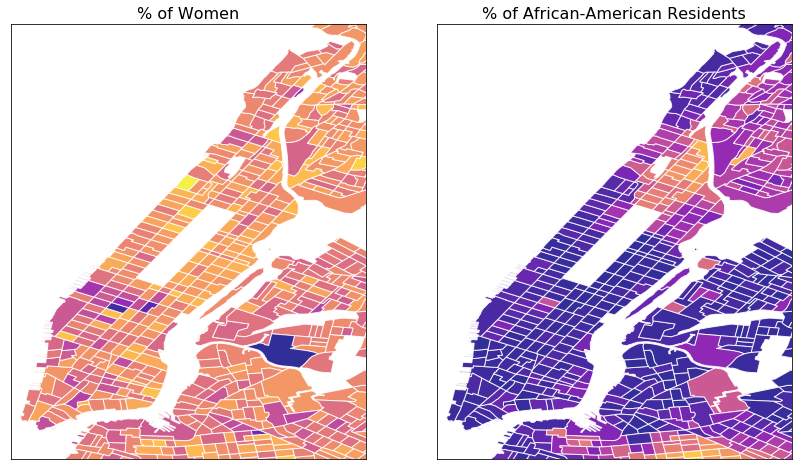

In [53]:
fig, ax = plt.subplots(1, 2, figsize = (14, 8)) 
nyc.plot(ax = ax[0], edgecolor='white', column = "women", cmap = "plasma", alpha = 0.85) 
nyc.plot(ax = ax[1], edgecolor='white', column = "af_am", cmap = "plasma", alpha = 0.85) 

x1, x2, y1, y2 = 978000, 1010000, 189800, 260100

for i in range(0, 2):
    ax[i].get_xaxis().set_visible(False) 
    ax[i].get_yaxis().set_visible(False)
    ax[i].set_xlim(x1, x2)
    ax[i].set_ylim(y1, y2)

ax[0].set_title("% of Women", size  = 16)
ax[1].set_title("% of African-American Residents", size  = 16)
plt.show()

Though there is variation (e.g. the 'hotspot' that is Barnard college's census tract), women are (almost) everywhere in a roughly even proportion. African-Americans are not.

Looking back at maps shown before, it turns out these neighborhoods identified earlier do not only have extremely high incomes per capita, they are also overwhelmingly white.

It could be that *racial differences in earnings and wealth* prevent the integration of neighborhoods (an explanation common in the literature). If that were so, we could reasonably expect the wealthiest African-American households to locate in the same neigbhorhoods as the wealthiest White households.

The map below shows the distribution of both African-American and White households with an annual income of over 200,000 dollars.

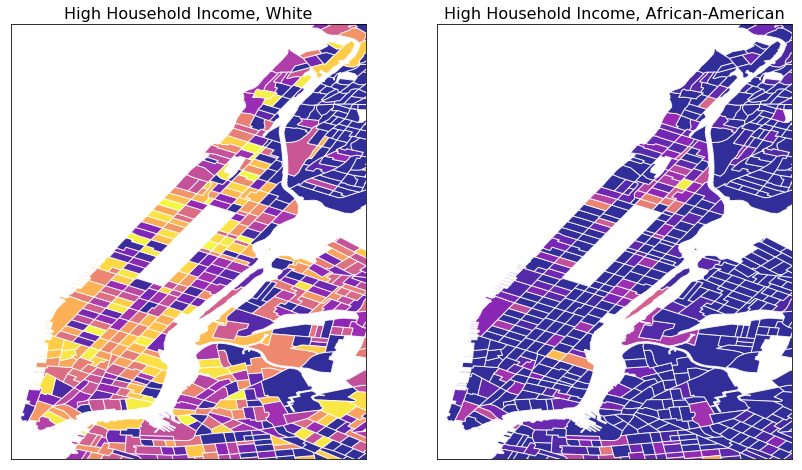

In [54]:
fig, ax = plt.subplots(1,2, figsize = (14,8))
nyc.plot(ax = ax[0], edgecolor='white', column = "B19001A_017E", cmap = "plasma", alpha = 0.85) 
nyc.plot(ax = ax[1], edgecolor='white', column = "B19001B_017E", cmap = "plasma", alpha = 0.85) 

x1, x2, y1, y2 = 978000, 1010000, 189800, 260100 #ax limits

for i in [0, 1]:
    ax[i].set_xlim(x1, x2)
    ax[i].set_ylim(y1, y2)
    ax[i].get_xaxis().set_visible(False) 
    ax[i].get_yaxis().set_visible(False)

ax[0].set_title("High Household Income, White", size  = 16)
ax[1].set_title("High Household Income, African-American", size  = 16)
plt.show()

Rich white households can be found anywhere in Manhattan, including in neighborhoods which are predominantly African-American but rich African-American households are primarly located in Harlem. 

This particular household income category has no upper bound so it could be that the average White household in that category has a higher income than the average African-American household. This hidden difference could result in greater mobility for White households, resulting in the pattern above. 

I therefore plot a similar map, this time showing the second highest tranche of household income only. This tranche is bounded between 150,000 and 199,999 dollars, so the comparison is sure to be relatively fair.

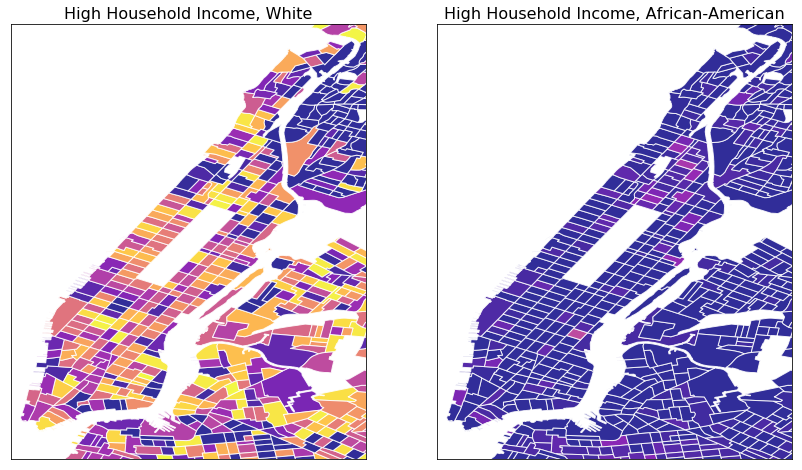

In [55]:
fig, ax = plt.subplots(1,2, figsize = (14,8))
nyc.plot(ax = ax[0], edgecolor='white', column = "B19001A_016E", cmap = "plasma", alpha = 0.85) 
nyc.plot(ax = ax[1], edgecolor='white', column = "B19001B_016E", cmap = "plasma", alpha = 0.85) 

x1, x2, y1, y2 = 978000, 1010000, 189800, 260100 #ax limits

for i in [0, 1]:
    ax[i].set_xlim(x1, x2)
    ax[i].set_ylim(y1, y2)
    ax[i].get_xaxis().set_visible(False) 
    ax[i].get_yaxis().set_visible(False)

ax[0].set_title("High Household Income, White", size  = 16)
ax[1].set_title("High Household Income, African-American", size  = 16)
plt.show()

The pattern found previously persists, which implies that *income can not be the sole factor explaining the enduring patterns of residential segregation we observe in NYC today*. In other words, the very high income-per-capita neighborhoods are made up of households which cluster by income group and by race.

An aritcle by the [New York Times](https://www.nytimes.com/2012/08/07/nyregion/on-upper-east-side-racial-disparity-remains.html) provides illustrative examples which may explain why this Upper East Side cluster persists: firstly, minorities may not feel welcome in the neighborhood, either due to reactions from their neighbors or the police. For instance, the article notes that "Sakinah Ali, a 35-year-old black woman who has lived on East 84th Street for about eight years, said people often thought she was in the neighborhood for work when she was just a block or two from home". Secondly, they can be the victim of outright discrimination when trying to relocate to the UES. The same New York Times' article notes: "real estate professionals say some Upper East Side co-ops have a reputation for rejecting black buyers — and in some cases, Jewish buyers — even if they seem perfectly qualified".

### Case Studies

#### Income Inequality in the Upper East Side/East Harlem South

I can now go back to the Upper East Side/East Harlem South. As two of the neighborhoods with the highest Gini Coefficients, this will serve as my illustrative case study of income inequality in the city.

In [56]:
ues_ehs = (nyc["tract"] == "016001") | (nyc["tract"] == "016800") & (nyc["county"] == "Manhattan") #conditions to select tracts

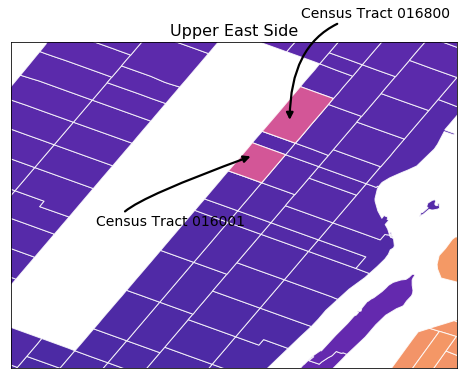

In [57]:
fig, ax = plt.subplots(figsize = (8,6))
nyc.plot(ax = ax, edgecolor='white', cmap = "plasma", alpha = 0.85) 
nyc[ues_ehs].plot(ax = ax, edgecolor='white', color = "#ea5f94", alpha = 0.85)  #overlays neighborhoods of interest

ax.set_xlim(990000, 1002000) #set axis of maps
ax.set_ylim(217000, 230500)
ax.get_xaxis().set_visible(False) #removes axis of maps
ax.get_yaxis().set_visible(False)

ax.annotate( #arrow to bottom bar chart
    "Census Tract 016001", 
    xy = (996500, 225800), 
    xytext= (992300, 222900),
    xycoords="data", 
    arrowprops={
        "arrowstyle": "-|>", 
        "connectionstyle": "angle3,angleA=5,angleB=20",
        "color": "black",
        "lw" : "2.2"
    },
    size = 14
)

ax.annotate( #arrow to top bar chart
    "Census Tract 016800", 
    xy = (997500, 227200), 
    xytext= (997800, 231500),
    xycoords="data", 
    arrowprops={
        "arrowstyle": "-|>", 
        "connectionstyle": "angle3,angleA=5,angleB=90",
        "color": "black",
        "lw" : "2.2"
    },
    size = 14
)

ax.set_title("Upper East Side", size  = 16)

plt.show()

Census Tract 016001 (**161** in the table, part of the Upper East Side NTA) is located between 5th Ave and Park Avenue, from 91st to 96th st. Census Tract 016800 (**170** in the table, part of the East Harlem South NTA) is just a couple of block upwards, from 98th st to 106th st. Yet the differences across the two are staggering.

In [58]:
nyc[ues_ehs][["B19001_002E", "pop", "per_cap_income", "house_income", "house_income_famsize"]]

,B19001_002E,pop,per_cap_income,house_income,house_income_famsize
161,41.0,3861.0,189772.0,222222.0,250001.0
170,340.0,4693.0,27423.0,26136.0,32813.0


Recall "B19001_002E" is an income tranche that records the number of households with a household income of below 10,000 dollars per year (below the poverty line). There obviously is a lot more 'poor' households in tract 016800 than in 016001. Per capita income, household income, and household income per family size all show a large economic gap between the tracts: the per capita income in the UES tract is roughly seven times that of the EHS tract.

The code below will allows us to show the distribution of income *per household*, by shaping the tranches of household income (the B19001_002E to B19001_017E codes) into a 'long' form.

In [59]:
ues = nyc[(nyc["county"] == "Manhattan") & (nyc["tract"] == "016001")]
ues = pd.melt(ues, id_vars=["NTAName", 'county', 'state', 'tract'], value_vars=['B19001_002E', 'B19001_003E', 'B19001_004E', 'B19001_005E',
       'B19001_006E', 'B19001_007E', 'B19001_008E', 'B19001_009E',
       'B19001_010E', 'B19001_011E', 'B19001_012E', 'B19001_013E',
       'B19001_014E', 'B19001_015E', 'B19001_016E', 'B19001_017E'])
ehs = nyc[(nyc["county"] == "Manhattan") & (nyc["tract"] == "016800")]
ehs = pd.melt(ehs, id_vars=["NTAName", 'county', 'state', 'tract'], value_vars=['B19001_002E', 'B19001_003E', 'B19001_004E', 'B19001_005E',
       'B19001_006E', 'B19001_007E', 'B19001_008E', 'B19001_009E',
       'B19001_010E', 'B19001_011E', 'B19001_012E', 'B19001_013E',
       'B19001_014E', 'B19001_015E', 'B19001_016E', 'B19001_017E'])

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


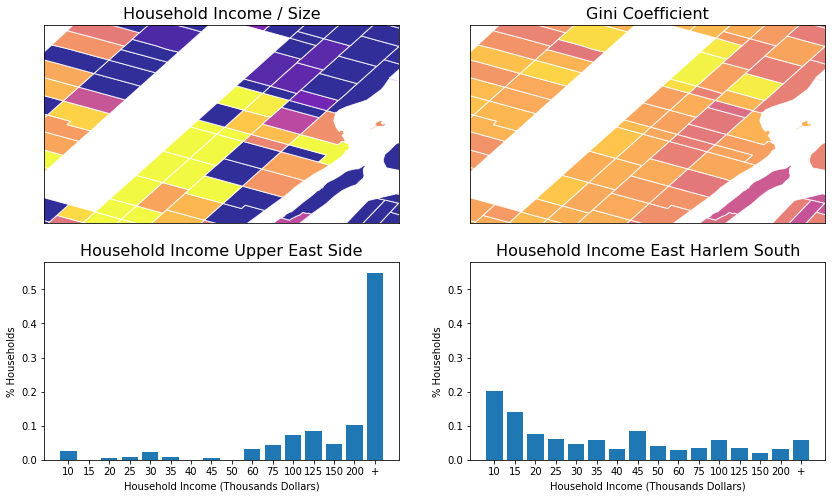

In [60]:
fig, ax = plt.subplots(2, 2, figsize = (14,8))
nyc.plot(ax = ax[0,0], edgecolor='white', column = "house_income_famsize", cmap = "plasma", alpha = 0.85) 
nyc.plot(ax = ax[0,1], edgecolor='white', column = "gini", cmap = "plasma", alpha = 0.85)
ax[1,0].bar(ues["variable"].unique(), ues.groupby("variable").sum()["value"] / ues.groupby("variable").sum()["value"].sum())
ax[1,1].bar(ehs["variable"].unique(), ehs.groupby("variable").sum()["value"] / ehs.groupby("variable").sum()["value"].sum())
#on the x axis of the bar chart, each 'tranche' of income
#on the y axis, the number of households in the whole NTA (i.e. the sum of census track data) / total households in NTA
#i.e. the % of households in the NTA belonging to a certain tranche

for i in [0, 1]:
    ax[0,i].set_xlim(990000, 1002000) #set axis of maps
    ax[0,i].set_ylim(217000, 230500)
    ax[1,i].set_ylim(0, 0.58) #set axis of bar charts so they are comparable 
    ax[0,i].get_xaxis().set_visible(False) #removes axis of maps
    ax[0,i].get_yaxis().set_visible(False)
    ax[1,i].set_xticklabels(["10", "15", "20", "25", "30", "35", "40", "45", "50", "60", "75", "100", "125", "150", "200", "+"])
    ax[1,i].set_ylabel("% Households")
    ax[1,i].set_xlabel("Household Income (Thousands Dollars)")

ax[0,0].set_title("Household Income / Size", size  = 16)
ax[0,1].set_title("Gini Coefficient", size  = 16)

ax[1,0].set_title("Household Income Upper East Side", size  = 16)
ax[1,1].set_title("Household Income East Harlem South", size  = 16)

plt.show()

More than **half** of households in Census Tract 016001 (in the Upper East Side NTA) have an annual income of **over** 200,000 dollars per year. By contrast, **20%** of households in Census Tract 016800 (in the East Harlem South NTA) have an annual income **below** 10,000 dollars per year.

I now quickly look at some of the factors I explored above, in the context of the UES/EHS, starting with education:

In [61]:
nyc[ues_ehs][["edu_hs", "edu_college"]]

,edu_hs,edu_college
161,0.042217,0.528102
170,0.180055,0.177711


Tract 016001 is much more educated (by those measures) than tract 016800: indeed, there is twice the percentage of college graduates in the former than high school and college in the latter.

In [62]:
nyc[ues_ehs][["edu_ba", "edu_ma", "edu_phd"]]

,edu_ba,edu_ma,edu_phd
161,0.249935,0.226625,0.051541
170,0.132751,0.040060,0.004901


When breaking it down by degree, it appears that tract 016001 has twice the number of Masters and PhD holders than the borough average. Though tract 016800 is closer to the other boroughs' averages.

In [63]:
nyc[ues_ehs][["sec_a", "sec_b", "sec_c"]]

,sec_a,sec_b,sec_c
161,0.036384,0.047186,0.819784
170,0.054144,0.102941,0.792112


However, roughly the same percentage of the *working* population in both tracts work in the 'quaternary' sector.

In [64]:
nyc[ues_ehs][["work_info", "work_finance",  "work_science", "work_education", "work_arts"]]

,work_info,work_finance,work_science,work_education,work_arts
161,0.044912,0.251279,0.263218,0.229676,0.030699
170,0.059492,0.064171,0.176471,0.375000,0.116979


The job composition per industry is quite different across those two tracts. Tract 016800 has more people working in "educational services, ...health care and social assistance" and the "arts, entertainment, and recreation, and accommodation and food services" -- e.g. the lower paying 'quaternary' industries. The Upper East Side tract, by contrast, has four times the number of people working in the (high-paying) financial sector. Therefore the income per capita patterns in both tracts remain consistent with the theory discussed earlier. 

In [65]:
nyc[ues_ehs][["white", "af_am", "asian"]]

,white,af_am,asian
161,0.902098,0.003367,0.068635
170,0.353505,0.389729,0.050714


Finally, it is worth noting that tract 016001 is 90.21 percent white -- well above the borough's overall percentage of white residents (57.02 percent) -- and 0.34 percent African-American. This is a damning evidence of residential segregation, as the borough average is of 15.53 percent and tract 016800's population is 38.97 percent African-American.

---

## Conclusion

I was able to show, at the conclusion of this project, how income was distributed across the city; how this distribution relates to that of education, and more specifically high school, Bachelors', Masters', and Doctorates, as well as that of workers per industry and race; and do a close study of two census tracts in one of the most unequal areas in New York City.

Though (hopefully) interesting, this project had a rather limited scope. It was unable to add considerations of gender discrimination or age/experience wage-differentials. It also only had a cursory approach to racial discrimination in New York City. Other factors determining the location decision of individuals, such as the distance to work, rent, and the business/entertainment composition of the neigbhorhood, were also absent. Finally, the study was only able to look at a snapchat in time of New York City, and was therefore unable to observe or discuss the recent changes the city has undergone. 

## Sources

#### Bibliography
- Aaronson, Daniel, Hartley, Daniel, and Mazumder, Bhash. "The Effects of the 1930s HOLC “Redlining” Maps", 2017, *Federal Reserve Bank of Chicago*, Working Paper, No. 2017-12, 2017. Retrieved from [url](https://www.chicagofed.org/publications/working-papers/2017/wp2017-12).
- Autor, David H. and Katz, Lawrence F. "Changes in the Wage Structure and Earnings Inequality", 1999, *Handbook of Labor Economics*  Vol. 3, Edited by O. Ashenfeher and D. Card. Retrieved from [url](https://economics.mit.edu/files/11676)
- Autor, David H. "Skills, education, and the rise of earnings inequality among the 'other 99 percent'", 23 May 2014, *Science*. Retrieved from [url](http://piketty.pse.ens.fr/files/Autor2014.pdf)
- Chetty, Raj, Nathaniel, Hendren, Kline, Patrick & Saez, Emmanuel. "Where is the Land of Opportunity? The Geography of Intergenerational Mobility in the United States", January 2014, *National Bureau of Economic Research*, Working Paper 19843. Retrieved from [url](http://www.nber.org/papers/w19843)
- Depalma, Anthony. "Is The Upper East Side Moving North?", *The New York Times*, January 31, 1988. Retrieved from [url](https://www.nytimes.com/1988/01/31/realestate/is-the-upper-east-side-moving-north.html?pagewanted=1)
- Desilver, Drew. "College enrollment among low-income students still trails richer groups", *Pew Research*, January 15, 2014. Retrieved from [url](http://www.pewresearch.org/fact-tank/2014/01/15/college-enrollment-among-low-income-students-still-trails-richer-groups/)
- Goldin, Claudia & Katz, Lawrence F. "The Race between Education and Technology: The Evolution of U.S. Educational Wage Differentials, 1890 to 2005", May 2009, *National Bureau of Economic Research*, Working Paper 12984. Retrieved from [url](http://piketty.pse.ens.fr/files/GoldinKatz2009.pdf)
- Greenstone, Michael, *et al*. "Thirteen Economic Facts about Social Mobility and the Role of Education", *The Hamilton Project*, June 2013. Retrieved from [url](https://www.brookings.edu/wp-content/uploads/2016/06/THP_13EconFacts_FINAL.pdf) 
- Harris, Elizabeth A. "A Stubborn Racial Disparity in Who Calls the Upper East Side Home", *The New York Times*, August 6, 2012. Retrieved from [url](https://www.nytimes.com/2012/08/07/nyregion/on-upper-east-side-racial-disparity-remains.html)
- International Monetary Fund. "Financial Crises, Poverty, and Income Distribution", January 1, 2002. Retrieved from [url](https://www.imf.org/en/Publications/WP/Issues/2016/12/30/Financial-Crises-Poverty-and-Income-Distribution-15562)
- Piketty, Thomas and Saez, Emmanuel. "Income Inequality in the United States, 1913-1998", February 2003, *The Quarterly Journal of Economics* Vol. CXVIII. Retrieved from [url](https://eml.berkeley.edu/~saez/pikettyqje.pdf)
- Piketty, Thomas and Saez, Emmanuel. "Inequality in the long run", 23 May 2014, *Science*. Retrieved from [url](http://piketty.pse.ens.fr/files/PikettySaez2014Science.pdf)
- Rothstein, Richard. *The Color of Law*. (Liverright Publishing: New York, 2017). Print.

#### Data
- New York City, Department of Planning. (2018) Political and Administrative Districts [Census Tracts 2010 (Clipped to Shoreline)]. Retrieved from [url](https://www1.nyc.gov/site/planning/data-maps/open-data/districts-download-metadata.page).
- United States Census Bureau. (2016). American Community Survey. Retrieved from Census API, in notebook.